In [145]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import matplotlib.pyplot as plt
from dataset import EEGDataset
from filter  import Filter
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
file_path_1 = "../BCICIV_1_mat/BCICIV_calib_ds1a"
data = EEGDataset(file_path_1, start_window=0.5, end_window=3)

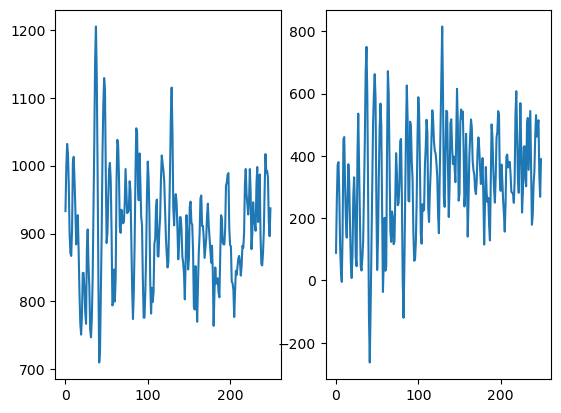

In [98]:
transformed = Filter.laplacian_filter(data)
plt.subplot(1, 2, 1)
plt.plot(data.trials[100][20])
plt.subplot(1, 2, 2)
plt.plot(transformed[100][20])
plt.show()

## Filters

In [148]:
data.trials = Filter.laplacian_filter(data)

In [157]:
fmin, fmax = 8, 40
data.trials = mne.filter.filter_data(data.trials.astype(np.float64), sfreq=data.sampling_frequency, l_freq=fmin, h_freq=fmax)

Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    2.0s finished


In [156]:
# data.trials = Filter.bandpass_filter(data)
data.trials = Filter.CAR_filter(data)


## Train Test Split

In [158]:
X = data.trials.astype(np.float64)
y = data.targets.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=40,
    stratify=y
)

## ICA

In [113]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=59, random_state=42, max_iter=300)
X_train_ica = ica.fit_transform(X_train.reshape(-1, 59 * 200), y_train)
X_test_ica = ica.transform(X_test.reshape(-1, 59 * 200))

ValueError: cannot reshape array of size 2212500 into shape (11800)

In [36]:
X_train_csp = X_train_ica
X_test_csp = X_test_ica

## CSP

In [159]:
import numpy as np
from mne.decoding import CSP

n_components = 59
csp = CSP(n_components=n_components, reg=None, log=None, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None
    Using tolerance 1.5e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=-1.0 covariance using EMPIRICAL
Done.
Estimating class=1.0 covariance using EMPIRICAL
Done.


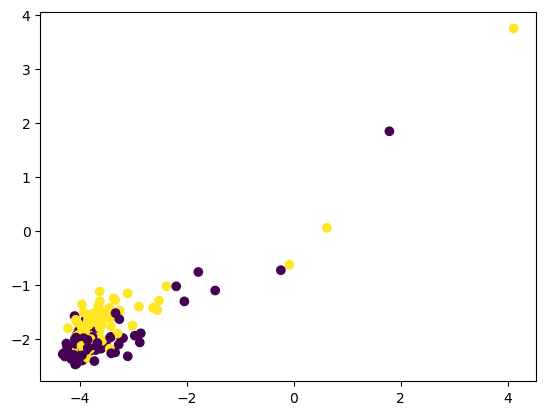

In [41]:
plt.scatter(X_train_csp[:,0], X_train_csp[:,1], c=y_train)

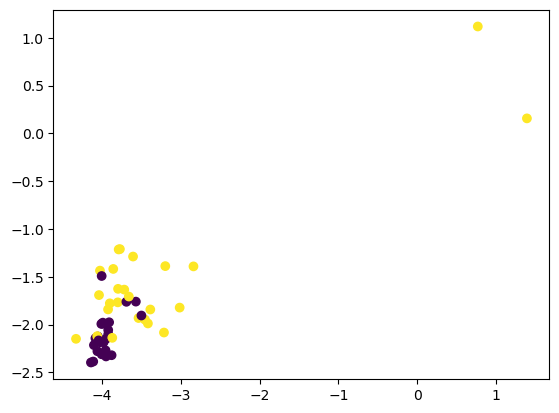

In [42]:
plt.scatter(X_test_csp[:,0], X_test_csp[:,1], c=y_test)

In [12]:
np.unique(y_test, return_counts=True)

(array([-1.,  1.]), array([25, 25]))

## Logistic Regression

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=300)
model.fit(X_train_csp, y_train)
y_pred = model.predict(X_test_csp)
accuracy_score(y_test, y_pred)

0.9

## SVM

In [161]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=1.0)
model.fit(X_train_csp, y_train)
y_pred = model.predict(X_test_csp)
accuracy_score(y_test, y_pred)

0.92

## KNN

In [162]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_csp, y_train)
y_pred = model.predict(X_test_csp)
accuracy_score(y_test, y_pred)

0.88

## MLP

In [143]:
from mlp import TorchDataset, MLP, NNTrainTest
import torch
import torch.nn as nn
import torch.optim as optim

In [144]:
num_classes = 2
num_epochs = 2
batch_size = 64
learning_rate = 0.001
input_shape = (-1, 59)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp_clf = MLP(input_shape, num_classes).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_clf.parameters(), lr=learning_rate)

NNTrainTest(mlp_clf, device).train(num_epochs, TorchDataset(X_train_csp, y_train), batch_size, learning_rate)

NNTrainTest(mlp_clf, device).test(TorchDataset(X_test_csp, y_test), batch_size)

Accuracy on test dataset: 76.0%
